# Lecture 6a: Neural Network Learning Part 4

3/16/2023

## Using Keras Library:
 - Binary Classification

#### Import Libraries:

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from random import randint
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score, confusion_matrix

#### Define Functions For Plotting:

In [27]:
# plot data points
def plot_fun(features, labels, classes, plotRange):
    plt.plot(features[labels[:] == classes[0], 0], features[labels[:] == classes[0], 1], 'rs',
             features[labels[:] == classes[1], 0], features[labels[:] == classes[1], 1], 'g^')
    plt.axis(plotRange)
    plt.title('Raw Data Plot For Both Classes')
    plt.xlabel('X_1: Feature 1')
    plt.ylabel('X_2: Feature 2')
    plt.legend(['Class ' + str(classes[0]), 'Class ' + str(classes[1])])
    plt.show()

# plot separating line: w1x1 + w2x2 + w0 = 0
def plot_fun_thr(features, labels, thresholdParams, learnRate, batchSize, classes):
    # plot data points
    plt.plot(features[labels[:] == classes[0], 0], features[labels[:] == classes[0], 1], 'rs',
             features[labels[:] == classes[1], 0], features[labels[:] == classes[1], 1], 'g^')
    plt.axis([-3, 3, -2, 4])
    # plot separating line
    x1 = np.linspace(-3, 3, 50)
    # w1x1 + w2x2 + w0 = 0 => x2 = -(w1x1 + w0) / w2
    x2 = -(thresholdParams[0] * x1 + thresholdParams[2]) / thresholdParams[1]
    plt.plot(x1, x2, '-b')
    plt.title(f'Data Classification:\nLearn Rate = {learnRate}, Batch Size = {batchSize}')
    plt.xlabel('X_1: Feature 1')
    plt.ylabel('X_2: Feature 2')
    plt.legend(['Class ' + str(classes[0]), 'Class ' + str(classes[1])])
    #plt.pause(0.5)
    #plt.show()

# plot training accuracy and loss
def plotCurve(trainingAccuracy, trainingLoss):
    epochs = np.arange(trainingLoss.shape[0])
    #print(epochs)
    plt.figure(figsize = [12, 6])
    plt.subplot(1, 2, 1)
    plt.plot(epochs, trainingAccuracy)
    #plt.axis([-1, 2, -1, 2])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, trainingLoss)
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy Loss')
    plt.title('Training Loss')
    plt.show()

# Plot MNIST Images in subplots
def img_plt(img, label):
    plt.figure(figsize=(12, 5.5))
    for i in range (1, 11):
        plt.subplot(2, 5, i)
        plt.imshow(img[i - 1, :, :], cmap = 'gray')
        plt.title('Label: ' + str(label[i - 1]))
    plt.show()

# Plot Features of MNIST data
def feat_plot(features, labels, classes, title):
    for class_i in classes:
        plt.plot(features[labels[:] == classes[class_i], 0],
                 features[labels[:] == classes[class_i], 1], 'o', markersize = 5)
        # plt.axis([-2, 2, -2, 2])
        plt.xlabel('X: Feature 1')
        plt.ylabel('Y: Feature 2')
        plt.title(title)
        plt.legend(['Class ' + str(classes[class_i]) for class_i in classes])
    plt.show()

#### Define Function For Feature Extraction From MNIST Images:

In [45]:
def feat_extract_bin(images):
    # Divide Each Image into 4 quadrants
    features = np.zeros((images.shape[0], 4))
    
    features_temp = np.sum(images[:, 0:int(images.shape[1] / 2), 0:int(images.shape[2] / 2)], axis = 2) # Quadrant 0
    features[:,0] = np.sum(features_temp, axis = 1) / (14*14) # Average Pixel Values
    
    features_temp = np.sum(images[:, 0:int(images.shape[1] / 2), int(images.shape[2] / 2):], axis = 2) # Quadrant 1
    features[:,1] = np.sum(features_temp, axis = 1) / (14*14) # Average Pixel Values
    
    features_temp = np.sum(images[:, int(images.shape[1] / 2):, 0:int(images.shape[2] / 2)], axis = 2) # Quadrant 2
    features[:,2] = np.sum(features_temp, axis = 1) / (14*14) # Average Pixel Values
    
    features_temp = np.sum(images[:, int(images.shape[1] / 2):, int(images.shape[2] / 2):], axis = 2) # Quadrant 3
    features[:,3] = np.sum(features_temp, axis = 1) / (14*14) # Average Pixel Values
    return features

## Keras For Binary Classification:

#### Load MNIST Dataset & Split Into Training & Testing Sets:

In [29]:
# Load Data and Split to Training and Testing Sets:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#print(x_train.shape) # (60000, 28, 28)
#print(y_train.shape) # (60000,)
#print(x_test.shape) # (10000, 28, 28)
#print(y_test.shape) # (10000,)

print('The number of Training Images =', x_train.shape[0])
print('The number of Training Labels =', y_train.shape[0])
print('The size of each Training Image is:', x_train.shape[1], 'by', x_train.shape[2], 'pixels \n')
print('The number of Testing Images =', x_test.shape[0])
print('The number of Testing Labels =', y_test.shape[0])
print('The size of each Testing Image is:', x_test.shape[1], 'by', x_test.shape[2], 'pixels')

The number of Training Images = 60000
The number of Training Labels = 60000
The size of each Training Image is: 28 by 28 pixels 

The number of Testing Images = 10000
The number of Testing Labels = 10000
The size of each Testing Image is: 28 by 28 pixels


#### Plot Digits 0 - 9 From The Training Set:

 - For Each Digit, Select A Random Sample.

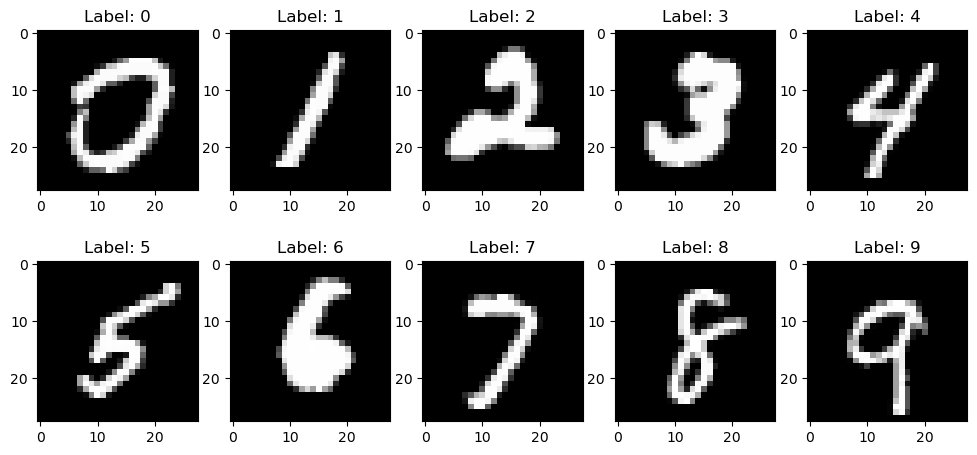

In [30]:
# Select 10 images from the training set
x_train_rnd = np.zeros((10, 28, 28))
y_train_rnd = np.arange(10)

for digit in range(10): # finds 10 images from the set
    x_train_d = x_train[y_train == digit,:,:]
    #x_train_rnd[digit,:,:] = x_train_d[0,:,:] # Select FIRST Digits From Set
    x_train_rnd[digit,:,:] = x_train_d[randint(0, x_train_d.shape[0]),:,:] # Select RANDOM Digits From Set

img_plt(x_train_rnd, y_train_rnd) # plot the images

#### Check Training and Test Sets:

In [31]:
# Check Training Data Set for correct amount of images:
x_train_TEST1 = x_train[y_train == 0] # Select all Zeros in Training Set
x_train_TEST2 = x_train[y_train == 1] # Select all Ones in Training Set
#print(x_train_TEST1.shape)
#print(x_train_TEST2.shape)
total1 = x_train_TEST1.shape[0] + x_train_TEST2.shape[0]
print(f'Total # of 0\'s and 1\'s in Training Set should be: {x_train_TEST1.shape[0]} + {x_train_TEST2.shape[0]} = {total1}\n')

# Check Test Data Set for correct amount of images:
x_test_TEST1 = x_test[y_test == 0] # Select all Zeros in Testing Set
x_test_TEST2 = x_test[y_test == 1] # Select all Ones in Testing Set
#print(x_test_TEST1.shape)
#print(x_test_TEST2.shape)
total2 = x_test_TEST1.shape[0] + x_test_TEST2.shape[0]
print(f'Total # of 0\'s and 1\'s in Test Set should be: {x_test_TEST1.shape[0]} + {x_test_TEST2.shape[0]} = {total2}\n')

Total # of 0's and 1's in Training Set should be: 5923 + 6742 = 12665

Total # of 0's and 1's in Test Set should be: 980 + 1135 = 2115



#### Select 0's and 1's From Training & Testing Sets:

In [32]:
## Actual Test and Training Set Declarations:
x_train_01 = x_train[np.logical_or(y_train == 1, y_train == 0),:,:] # Select ALL 1's and 0's from the Training Set.
y_train_01 = y_train[np.logical_or(y_train == 1, y_train == 0)] # Get labels for the digits.
#print(x_train_01.shape) # debug
#print(y_train_01.shape) # debug
print(f'Total Number of 0\'s and 1\'s in \'x_train_01\' is: {x_train_01.shape[0]}\n')

x_test_01 = x_test[np.logical_or(y_test == 1, y_test == 0),:,:] # Select ALL 1's and 0's from the Testing Set.
y_test_01 = y_test[np.logical_or(y_test == 1, y_test == 0)]
#print(x_test_01.shape) # debug
#print(y_test_01.shape) # debug
print(f'Total Number of 0\'s and 1\'s in \'x_test_01\' is: {x_test_01.shape[0]}\n')

Total Number of 0's and 1's in 'x_train_01' is: 12665

Total Number of 0's and 1's in 'x_test_01' is: 2115



#### Divide Training Set Into Training and Validation Sets

 - Create Shuffled Array Indices.
 - Shuffle Training and Testing Data.
 - Pull 1st 500 Images from Training Set and Designate as Validation Set.
    - The Remainder Of The Training Set is the New Training Set.

In [33]:
# create array with 11774 indices for TRAINING:
train_indices = np.arange(0, x_train_01.shape[0])
#print(train_indices)

# create array with 1954 indices for TESTING:
test_indices = np.arange(0, x_test_01.shape[0])
#print(test_indices, '\n')

# shuffle the indices of the training array
shuffled_indices_train = np.random.permutation(train_indices)
#print(shuffled_indices_train)

# shuffle the indices of the testing array
shuffled_indices_test = np.random.permutation(test_indices)
#print(shuffled_indices_test, '\n')

# create arrays of SHUFFLED TRAINING data
x_shuffled_all_train = x_train_01[shuffled_indices_train,:,:]
y_shuffled_all_train = y_train_01[shuffled_indices_train]
#print(x_shuffled_all_train.shape)
#print(y_shuffled_all_train.shape, '\n')

# create arrays of SHUFFLED TESTING data
x_shuffled_all_test = x_test_01[shuffled_indices_test,:,:]
y_shuffled_all_test = y_test_01[shuffled_indices_test]
#print(x_shuffled_all_test.shape)
#print(y_shuffled_all_test.shape, '\n')

# create validation set of 500 random images FROM SHUFFLED training set
x_valid_01 = x_shuffled_all_train[0:500,:,:]
y_valid_01 = y_shuffled_all_train[0:500]
print(x_valid_01.shape)
print(y_valid_01.shape, '\n')

# pull the rest of the images (11774 - 500 = 11274) FROM SHUFFLED training set
x_train_01 = x_shuffled_all_train[500:,:,:]
y_train_01 = y_shuffled_all_train[500:]
print(x_train_01.shape)
print(y_train_01.shape, '\n')

# SHUFFLE the TESTING Set
x_test_01 = x_shuffled_all_test[:]
y_test_01 = y_shuffled_all_test[:]
print(x_test_01.shape)
print(y_test_01.shape)

(500, 28, 28)
(500,) 

(12165, 28, 28)
(12165,) 

(2115, 28, 28)
(2115,)


#### Check Number Of Images In Training, Testing and Validation Sets:

In [34]:
print(f'The number of images in \'x_train_01\' Training Set = {x_train_01.shape[0]}')
print(f'The number of labels in \'y_train_01\' Training Set = {y_train_01.shape[0]}\n')

print(f'The number of images in \'x_valid_01\' Validation Set = {x_valid_01.shape[0]}')
print(f'The number of labels in \'y_valid_01\' Validation Set = {y_valid_01.shape[0]}\n')

print(f'The number of images in \'x_test_01\' Testing Set = {x_test_01.shape[0]}')
print(f'The number of labels in \'y_test_01\' Testing Set = {y_test_01.shape[0]}')

The number of images in 'x_train_01' Training Set = 12165
The number of labels in 'y_train_01' Training Set = 12165

The number of images in 'x_valid_01' Validation Set = 500
The number of labels in 'y_valid_01' Validation Set = 500

The number of images in 'x_test_01' Testing Set = 2115
The number of labels in 'y_test_01' Testing Set = 2115


#### Plot 10 Images From The Validation Set:

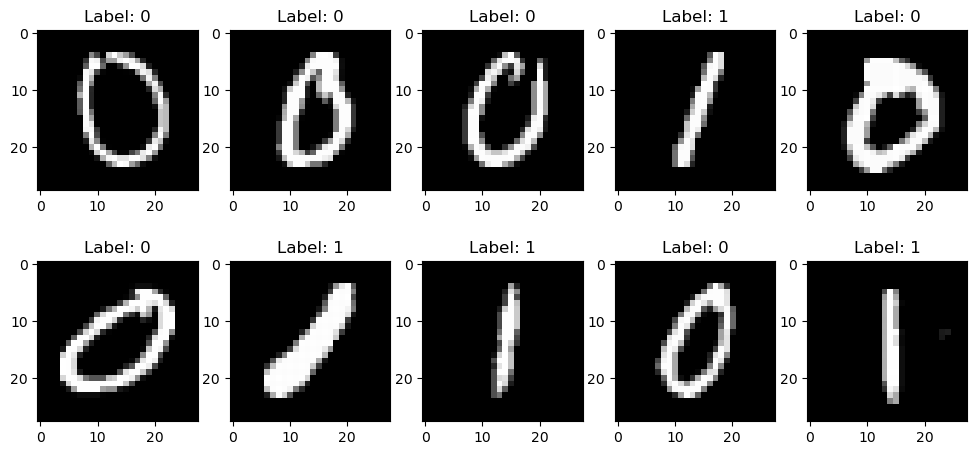

In [35]:
img_plt(x_valid_01[0:10,:,:], y_valid_01[0:10]) # Select First 10 images from the set

#### Extract Features And Calculate Average of Each Image Quadrant:

In [36]:
feature_train = feat_extract_bin(x_train_01)
feature_valid = feat_extract_bin(x_valid_01)
feature_test = feat_extract_bin(x_test_01)
classes1 = [0, 1]

#### Plot Features of 500 Training Images:

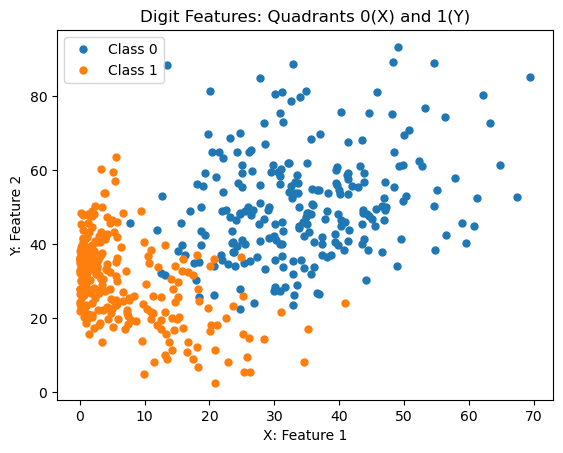

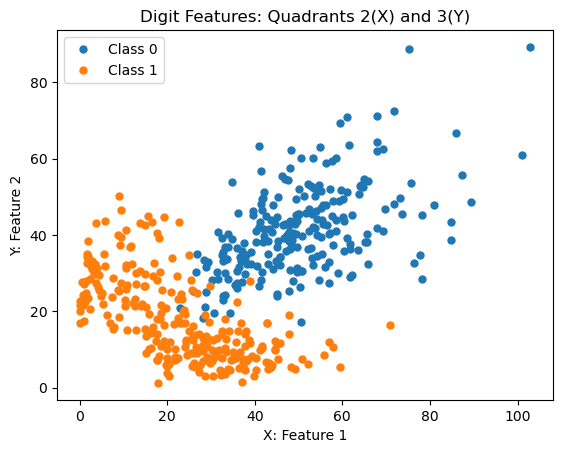

In [37]:
feat_plot(feature_train[0:500, 0:2], y_train_01[0:500], classes1, 'Digit Features: Quadrants 0(X) and 1(Y)')
feat_plot(feature_train[0:500, 2:4], y_train_01[0:500], classes1, 'Digit Features: Quadrants 2(X) and 3(Y)')

#### Define The Model:

In [38]:
model1 = Sequential()
model1.add(Dense(input_dim = 4, units = 128, activation = 'tanh')) # Hidden Layers
model1.add(Dense(units = 1, activation = 'sigmoid')) # Ouput Layer
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               640       
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


#### Compile, Fit and Evaluate Model:

In [39]:
# Stochastic Gradient Descent
opt = tf.keras.optimizers.SGD(learning_rate = 0.0001) # try 0.001, 0.01

model1.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

# Try batch_size = 16 & epochs = 5
history1 = model1.fit(feature_train, y_train_01, batch_size=32, epochs=35, verbose=1)

Epoch 1/35
381/381 [==============================] - 1s 1ms/step - loss: 0.5785 - accuracy: 0.7060
Epoch 2/35
381/381 [==============================] - 0s 794us/step - loss: 0.4310 - accuracy: 0.8318
Epoch 3/35
381/381 [==============================] - 0s 754us/step - loss: 0.3760 - accuracy: 0.8941
Epoch 4/35
381/381 [==============================] - 0s 815us/step - loss: 0.3429 - accuracy: 0.9208
Epoch 5/35
381/381 [==============================] - 0s 763us/step - loss: 0.3199 - accuracy: 0.9269
Epoch 6/35
381/381 [==============================] - 0s 753us/step - loss: 0.3029 - accuracy: 0.9300
Epoch 7/35
381/381 [==============================] - 0s 778us/step - loss: 0.2891 - accuracy: 0.9329
Epoch 8/35
381/381 [==============================] - 0s 730us/step - loss: 0.2775 - accuracy: 0.9343
Epoch 9/35
381/381 [==============================] - 0s 759us/step - loss: 0.2674 - accuracy: 0.9364
Epoch 10/35
381/381 [==============================] - 0s 802us/step - loss: 0.2584 

#### Plot The Accuracy and Training Loss:

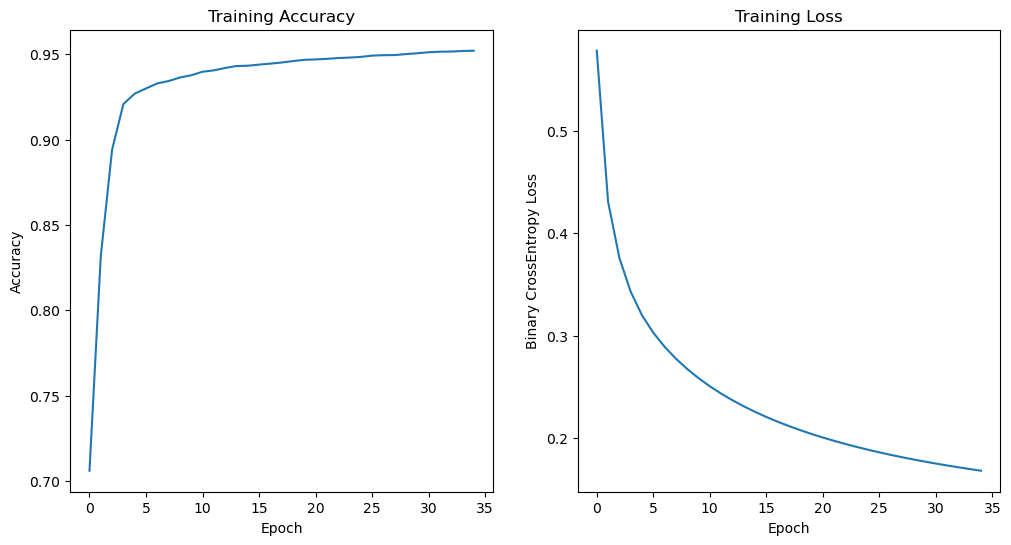

In [40]:
accuracyCurve = np.array(history1.history['accuracy'])
lossCurve = np.array(history1.history['loss'])

plotCurve(accuracyCurve, lossCurve)

#### Calculate Evaluation Metrics:

In [41]:
# Predict Class of Held-Out Samples:

testClass1Prob = model1.predict(feature_test)
testLabels1 = np.uint8(testClass1Prob > 0.5)

testAccuracy1 = accuracy_score(testLabels1, y_test_01)
print('Accuracy Using Testing Set: ', testAccuracy1, '\n')

confusionMatrix1 = confusion_matrix(testLabels1, y_test_01)
print('The Confusion Matrix Using Testing Set: \n', confusionMatrix1, '\n')

sensitivity = (confusionMatrix1[1,1] / (confusionMatrix1[1,0] + confusionMatrix1[1,1])) * 100
print(f'The Sensitivity Using The Testing Set = {sensitivity:0.2f} %')

specificity = (confusionMatrix1[0,0] / (confusionMatrix1[0,0] + confusionMatrix1[0,1])) * 100
print(f'The Specificity Using Testing Set = {specificity:0.2f} %')

67/67 [==============================] - 0s 577us/step
Accuracy Using Testing Set:  0.9635933806146572 

The Confusion Matrix Using Testing Set: 
 [[ 962   59]
 [  18 1076]] 

The Sensitivity Using The Testing Set = 98.35 %
The Specificity Using Testing Set = 94.22 %
